# Preparando o ambiente

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = None

# Importando dados

In [2]:
df_vehicles = pd.read_csv('../data/01_raw/electric_vehicle_title_and_registration_activity.csv', sep=',')

In [3]:
def normalize_columns(
    columns: pd.Series
) -> pd.Series:
    """
    Remove caracteres especiais e substitui espaços por "_",
    dada uma série de colunas.
    """
    return (
        columns
        .str.replace('[^-/\w\s]','', regex=True)
        .str.replace('\s','_', regex=True)
        .str.upper()
    )

In [4]:
def select_columns_by_type(
    df: pd.DataFrame,
    type: str
) -> list:
    """
    Seleciona colunas de um dataframe com base no tipo de dado fornecido.
    """
    cols = df.select_dtypes(include=[type]).columns.to_list()
    return cols


In [5]:
def normalize_object_columns(
    df: pd.DataFrame, columns: list[str]
) -> pd.DataFrame:
    """
    Padroniza colunas do tipo string (objeto).
    """
    for col in columns:
        df[col] = (
            df[col]
            .str.normalize("NFKD")
            .str.encode("ascii", errors="ignore")
            .str.decode("utf-8")
            .str.replace(r"\s+", " ", regex=True)
            .str.strip()
            .str.upper()
        )

    return df

In [6]:
def normalize_date_columns(
    df: pd.DataFrame,
    columns: list[str],
    format: str
) -> pd.DataFrame:
    """
    Converte colunas de datas do tipo string para datetime,
    seguindo um formato especificado.
    """
    for col in columns:
        df[col] = pd.to_datetime(df[col], format=format)

    return df

In [7]:
def remove_outlier(
    df: pd.DataFrame,
    column: str,
    return_outlier: bool = False
) -> pd.DataFrame:
    """
    Remove outlier pelo método de distância interquatílica.
    Se return_outlier for True, retorna apenas outliers da série.
    """

    # Intervalo interquartil
    p25 = df[column].quantile(0.25)
    p75 = df[column].quantile(0.75)
    iqr = p75 - p25
    
    # Limites inferior e superior
    lower = p25 - 1.5 * iqr
    upper = p75 + 1.5 * iqr

    if return_outlier:
        return df[(df[column] < lower) | (df[column] > upper)]
    else:
        return df[(df[column] >= lower) & (df[column] <= upper)]

# Normalizando base

In [8]:
def normalize_vehicles_database(
    df_vehicles: pd.DataFrame,
    date_cols: list[str],
) -> pd.DataFrame:
    """
    Normaliza cabeçalho e conteúdo de colunas da base de dados de veículos.
    """

    df_vehicles.columns = normalize_columns(df_vehicles.columns)

    object_cols = select_columns_by_type(df_vehicles,'object')
    df_vehicles = normalize_object_columns(df_vehicles, object_cols)

    date_cols = ['SALE_DATE', 'DOL_TRANSACTION_DATE']
    df_vehicles = normalize_date_columns(df_vehicles, date_cols, format=('%B %d %Y'))

    return df_vehicles

# Avaliações iniciais

In [9]:
df_vehicles.columns

Index(['CLEAN_ALTERNATIVE_FUEL_VEHICLE_TYPE', 'VIN_1-10', 'DOL_VEHICLE_ID',
       'MODEL_YEAR', 'MAKE', 'MODEL', 'VEHICLE_PRIMARY_USE', 'ELECTRIC_RANGE',
       'ODOMETER_READING', 'ODOMETER_CODE', 'NEW_OR_USED_VEHICLE',
       'SALE_PRICE', 'SALE_DATE', 'BASE_MSRP', 'TRANSACTION_TYPE',
       'DOL_TRANSACTION_DATE', 'TRANSACTION_YEAR', 'COUNTY', 'CITY',
       'STATE_OF_RESIDENCE', 'POSTAL_CODE',
       '2015_HB_2778_EXEMPTION_ELIGIBILITY',
       '2019_HB_2042_CLEAN_ALTERNATIVE_FUEL_VEHICLE_CAFV_ELIGIBILITY',
       'MEETS_2019_HB_2042_ELECTRIC_RANGE_REQUIREMENT',
       'MEETS_2019_HB_2042_SALE_DATE_REQUIREMENT',
       'MEETS_2019_HB_2042_SALE_PRICE/VALUE_REQUIREMENT',
       '2019_HB_2042_BATTERY_RANGE_REQUIREMENT',
       '2019_HB_2042_PURCHASE_DATE_REQUIREMENT',
       '2019_HB_2042_SALE_PRICE/VALUE_REQUIREMENT',
       'ELECTRIC_VEHICLE_FEE_PAID', 'TRANSPORTATION_ELECTRIFICATION_FEE_PAID',
       'HYBRID_VEHICLE_ELECTRIFICATION_FEE_PAID', '2020_CENSUS_TRACT',
       'LEGISLATI

In [64]:
print(df_vehicles['VEHICLE_PRIMARY_USE'].unique())
print(df_vehicles['ODOMETER_CODE'].unique())
print(df_vehicles['CLEAN_ALTERNATIVE_FUEL_VEHICLE_TYPE'].unique())

['PASSENGER' 'TRUCK' 'COMMERCIAL' 'EXEMPT (STATE/COUNTY/LOCAL/TRIBAL)'
 'FOR HIRE' 'CAB' 'MEDIUM-SPEED ELECTRIC VEHICLE' 'PRIVATE SCHOOL'
 'FARM EXEMPT' 'NEIGHBORHOOD ELECTRIC VEHICLE'
 'MEDIUM-SPEED ELECTRIC TRUCK' 'FARM USE' 'TAXI CAB']
['ODOMETER READING IS NOT COLLECTED AT TIME OF RENEWAL' 'ACTUAL MILEAGE'
 'NO ODOMETER CODE ON FILE'
 'EXEMPT - OVER 10 YEARS OLD, NON-POWERED, OR BY USE TYPE'
 'NOT ACTUAL MILEAGE' 'EXCEEDS MECHANICAL LIMITS'
 'EXEMPT - GROSS / TOWING RATING IS GREATER THAN 16,000']
['BATTERY ELECTRIC VEHICLE (BEV)' 'PLUG-IN HYBRID ELECTRIC VEHICLE (PHEV)'
 'HYDROGEN POWERED VEHICLE']


In [41]:
print(df_vehicles['VEHICLE_PRIMARY_USE'].value_counts())
print(f"\n{df_vehicles['ODOMETER_CODE'].value_counts()}")
print(f"\n{df_vehicles['TRANSACTION_TYPE'].value_counts()}")

PASSENGER                             770467
TRUCK                                   4362
EXEMPT (STATE/COUNTY/LOCAL/TRIBAL)      3899
COMMERCIAL                              2655
FOR HIRE                                 186
MEDIUM-SPEED ELECTRIC VEHICLE             82
NEIGHBORHOOD ELECTRIC VEHICLE             26
CAB                                       17
PRIVATE SCHOOL                             5
FARM USE                                   5
FARM EXEMPT                                4
TAXI CAB                                   3
MEDIUM-SPEED ELECTRIC TRUCK                2
Name: VEHICLE_PRIMARY_USE, dtype: int64

ODOMETER READING IS NOT COLLECTED AT TIME OF RENEWAL       507716
ACTUAL MILEAGE                                             249281
NO ODOMETER CODE ON FILE                                    24246
EXEMPT - OVER 10 YEARS OLD, NON-POWERED, OR BY USE TYPE       239
NOT ACTUAL MILEAGE                                            194
EXCEEDS MECHANICAL LIMITS                   

In [66]:
# Filtrando transações de venda de veículos usados e puramente elétricos com quilometragem válida.
df_2 = df_vehicles[
    (df_vehicles['SALE_PRICE'] > 0) &
    (df_vehicles['CLEAN_ALTERNATIVE_FUEL_VEHICLE_TYPE'] == 'BATTERY ELECTRIC VEHICLE (BEV)') &
    (df_vehicles['ODOMETER_CODE'] == 'ACTUAL MILEAGE') &
    (df_vehicles['NEW_OR_USED_VEHICLE'] == 'USED')
].reset_index(drop=True)

In [67]:
# Criando novas features
# Idade do carro
df_2['CAR_AGE'] = df_2['TRANSACTION_YEAR'] - df_2['MODEL_YEAR']
# Mês da venda
df_2['SALE_MONTH'] = df_2['SALE_DATE'].dt.strftime('%m').astype('int64')
# Preço de venda acima do preço de tabela
df_2['SALE_ABOVE_MSRP'] = (df_2['SALE_PRICE'] > df_2['BASE_MSRP']).astype('int64')
# Códigos para tipo de uso primário
df_2['CD_PRIMARY_USE'] = df_2['VEHICLE_PRIMARY_USE'].astype('category').cat.codes.astype('int64')

In [68]:
# Removendo outliers
df_2_wo_outlier = remove_outlier(df_2, 'SALE_PRICE')
df_2_wo_outlier = remove_outlier(df_2_wo_outlier, 'ODOMETER_READING')

In [71]:
df_2_wo_outlier[['VEHICLE_PRIMARY_USE', 'CD_PRIMARY_USE']].drop_duplicates().sort_values('CD_PRIMARY_USE').reset_index(drop=True)
# 1 e 8

,VEHICLE_PRIMARY_USE,CD_PRIMARY_USE
0,COMMERCIAL,0
1,EXEMPT (STATE/COUNTY/LOCAL/TRIBAL),1
2,FARM EXEMPT,2
3,FARM USE,3
4,FOR HIRE,4
5,MEDIUM-SPEED ELECTRIC VEHICLE,5
6,NEIGHBORHOOD ELECTRIC VEHICLE,6
7,PASSENGER,7
8,TRUCK,8


In [72]:
df_2_wo_outlier = df_2_wo_outlier[['CAR_AGE', 'SALE_MONTH', 'ODOMETER_READING', 'ELECTRIC_RANGE', 'SALE_PRICE', 'SALE_ABOVE_MSRP', 'CD_PRIMARY_USE']]

# Transformando variáveis numéricas em faixas
for c in ['ODOMETER_READING']:
    df_2_wo_outlier[c] = (df_2_wo_outlier[c]/50).astype(int) * 50

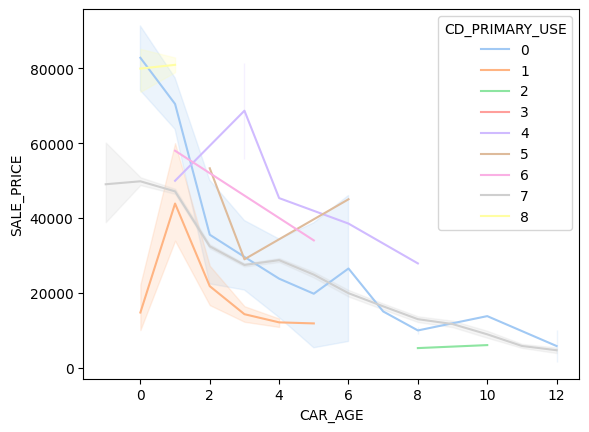

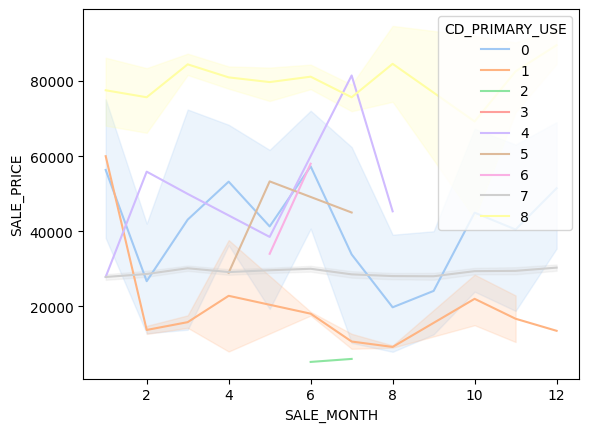

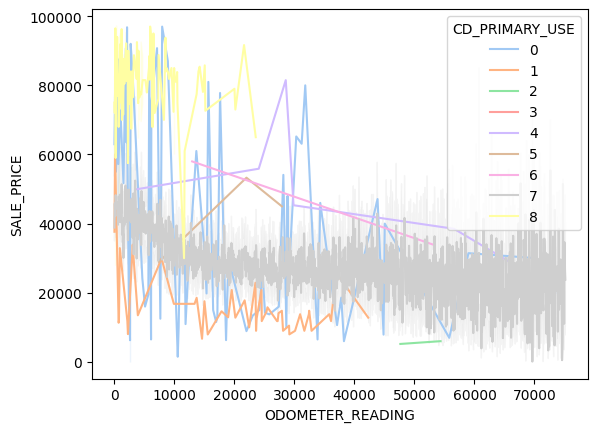

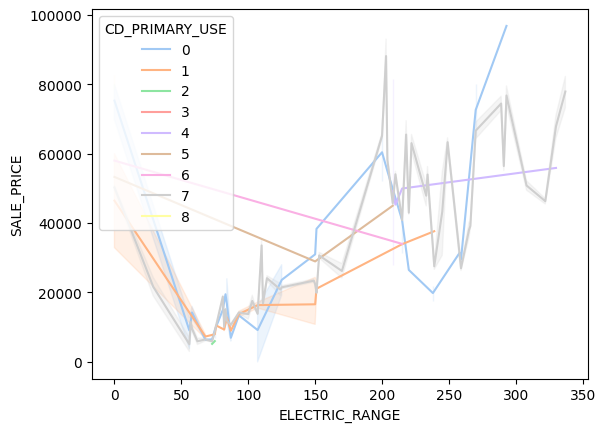

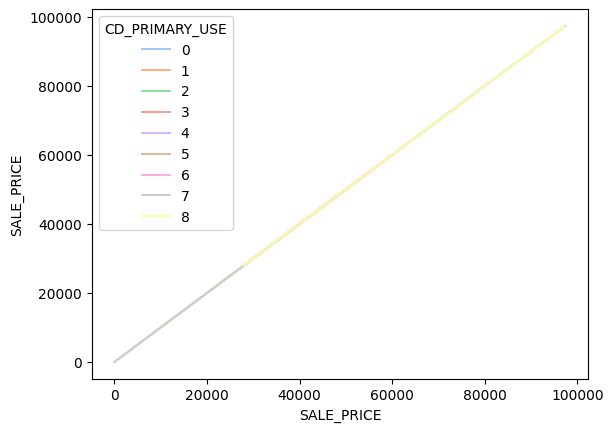

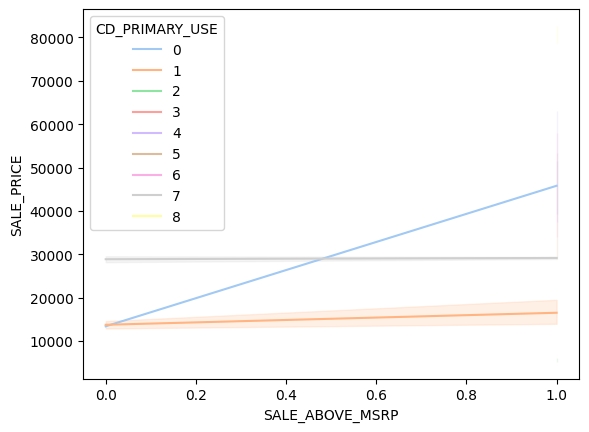

In [73]:
for c in df_2_wo_outlier.columns:
    if (c != 'CD_PRIMARY_USE'):
        sns.lineplot(data=df_2_wo_outlier, x=c, y='SALE_PRICE', hue='CD_PRIMARY_USE', palette='pastel')
        plt.show()